In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import *
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
path = './Data'
dfs = {}

files = os.listdir(path)
for f in files:
    _path = path + '/' + f
    if os.path.isfile(_path):
        dfs[_path] = pd.read_csv(_path)
    else:
        subfiles = os.listdir(_path)
        for sf in subfiles:
            _path = path + '/' + f + '/' + sf
            if os.path.isfile(_path):
                dfs[_path] = pd.read_csv(_path)
                
del dfs['./Data/wordPressNormalandAttack/NormalV1.1.csv']  # данные с сайта wordpress,
                                                           # они нам не нужны дл обучения              

In [4]:
df = pd.concat([i[1] for i in dfs.items()])
df = shuffle(df)
print('Признаки:\n', ', '.join(df.columns))
df.head()

Признаки:
 Row, udp, select, bin, run, poll, media, sys, dev, etc, usr, root, host, brk, boot, mkdir, write, connect, tcp, clone_API, proc, read, var, network_http, File_IO, kill_API, accept, home, munmap, mnt, opt, rename, srv, mmap, chdir_API, network_connection, execve_API, Normal, Attack


,Row,udp,select,bin,run,poll,media,sys,dev,etc,...,mnt,opt,rename,srv,mmap,chdir_API,network_connection,execve_API,Normal,Attack
1204,0,216,42,0,0,476,0,0,0,1950,...,0,0,0,0,1212,120,5096,54,0,1
2625,0,0,188,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3393,0,0,44,0,0,138,0,0,0,216,...,0,0,0,0,48,24,1401,0,0,1
1429,0,0,42,0,0,154,0,0,0,252,...,0,0,0,0,56,28,1588,0,0,1
1765,0,0,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
# данные несбалансированны
df.Attack.value_counts(normalize=True)

1    0.718122
0    0.281878
Name: Attack, dtype: float64

In [6]:
X, y = df.drop(['Normal', 'Attack'], axis=1), df.Attack

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [7]:
%%time

svm = SVC()
lg  = LogisticRegression()
knn = KNeighborsClassifier()
gbc = GradientBoostingClassifier()

for clf in [lg, knn, gbc]:
    clf.fit(X_train, y_train)
    print('\n\n', clf.__class__.__name__)
    print(classification_report(y_test, clf.predict(X_test)))
    print(confusion_matrix(y_test, clf.predict(X_test), labels=[0, 1]))



 LogisticRegression
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      2694
           1       0.91      0.97      0.94      7014

   micro avg       0.91      0.91      0.91      9708
   macro avg       0.91      0.86      0.88      9708
weighted avg       0.91      0.91      0.91      9708

[[2019  675]
 [ 206 6808]]


 KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2694
           1       1.00      1.00      1.00      7014

   micro avg       0.99      0.99      0.99      9708
   macro avg       0.99      0.99      0.99      9708
weighted avg       0.99      0.99      0.99      9708

[[2669   25]
 [  35 6979]]


 GradientBoostingClassifier
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2694
           1       1.00      1.00      1.00      7014

   micro avg       1.00      1.00      1.00      970

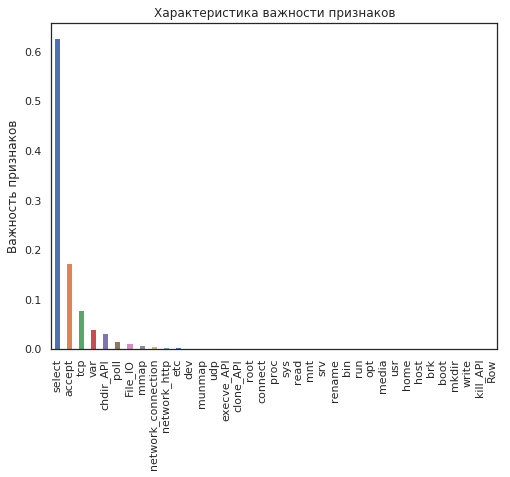

In [8]:
sns.set(font_scale=1)
sns.set_style("white")
fig = plt.figure(figsize=(8, 6))
ax = plt.axes()

feat_imp = pd.Series(gbc.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Характеристика важности признаков')
plt.xticks(rotation=90)
plt.ylabel('Важность признаков')
plt.show()

#plt.savefig('plot_feat_importance.png', bbox_inches = 'tight')

In [9]:
from sklearn.manifold import TSNE

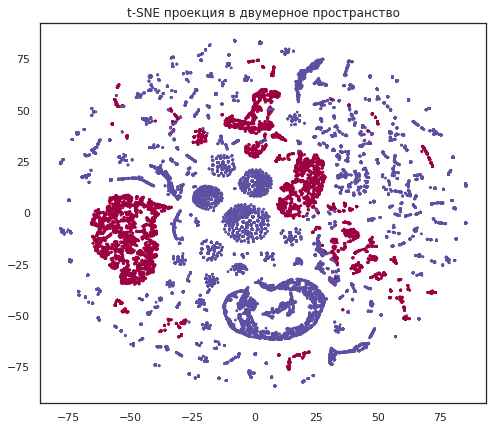

CPU times: user 4min 24s, sys: 364 ms, total: 4min 24s
Wall time: 4min 24s


In [16]:
# %%time
# tsne = TSNE(random_state=17)
# X_tsne = tsne.fit_transform(X)

# plt.figure(figsize=(8, 7))
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s = 3.5, c=y, cmap='Spectral')
# plt.title('t-SNE проекция в двумерное пространство')

# # plt.savefig('tsne_plot.png')
# plt.show()

Данные разбиты на кластеры, соотв разным типам атак. Для нас главное, что нормальное поведение тоже относительно неплохо группируется в отд кластеры <br/><br/>

<br/>Пробуем обучиться только на признаках, соответствующих syscalls, смотрим, как изменится качество

In [10]:
syscalls_ftrs = ['read', 'File_IO', 'write', 'accept', 'network_http', 'clone_API', 'select', 'poll', \
                 'rename', 'chdir_API', 'kill_API', 'mkdir', 'brk', 'mmap', 'munmap']

X_train, X_test, y_train, y_test = \
        train_test_split(df[syscalls_ftrs].values, df.Attack,test_size=0.3, random_state=17)

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

print(classification_report(y_test, gbc.predict(X_test)))
print(confusion_matrix(y_test, gbc.predict(X_test), labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2694
           1       1.00      1.00      1.00      7014

   micro avg       0.99      0.99      0.99      9708
   macro avg       0.99      0.99      0.99      9708
weighted avg       0.99      0.99      0.99      9708

[[2659   35]
 [  28 6986]]


Качество упало на 1%, что несущественно.<br/>
Результаты соответствуют полученным авторами статьи

### Работа с аномалиями

Поскольку реальные атаки могут отличаться от тех, которые попали в тренировочную выборку, возникла идея решит задачу поиска аномалий, <br/> т.е. взять примеры нормального поведения, обучить на них соотв. алгоритмы и посмотреть, насколько хорошо они детектируют аномалии (примеры атак) <br/>
Использовалось два подхода:<br/>
  + Novelty detection (считаем примеры в обучающей выборке неаномальными, смотрим, насколько на них непохожи все остальные)
  + Outlier detection (находим, где сконцентрированы примеры из обучающей выборки, далеко расположенные примеры считаем выбросами, в том числе из трейна)

In [11]:
# Разбиваем датасет на два, с нормальным поведением и аномалиями
# Также датасет с нормальным поведением разбиваем на трейн и тест

df_norm = df[df.Normal == 1].drop(['Normal', 'Attack'], axis=1)
df_atck = df[df.Attack == 1].drop(['Normal', 'Attack'], axis=1)

assert(len(df_norm) + len(df_atck) == len(df))

test_size=0.3
idx = int(len(df_norm)*(1 - test_size))
X_train, X_test = df_norm.iloc[:idx], df_norm.iloc[idx:]

Ниже ошибка алг на трейне, тесте и на датасете с аномалиями <br/>
Ошибку считаю, как долю соответствующих неправильных ответов

#### Novelty detection

In [12]:
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

svm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)

for clf in [svm, lof]:
    
    clf.fit(X_train)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_outliers = clf.predict(df_atck)

    errors = {}
    errors['n_error_train'] = y_pred_train[y_pred_train == -1].size / len(y_pred_train)
    errors['n_error_test'] = y_pred_test[y_pred_test == -1].size / len(y_pred_test)
    errors['n_error_outliers'] = y_pred_outliers[y_pred_outliers == 1].size / len(y_pred_outliers)

    print(F"\n{clf.__class__.__name__}")
    for name, e in errors.items():
        print(f"{name:17}: {round(e, 4)}")


OneClassSVM
n_error_train    : 0.4289
n_error_test     : 0.8137
n_error_outliers : 0.0073

LocalOutlierFactor
n_error_train    : 0.0919
n_error_test     : 0.1023
n_error_outliers : 0.1518


#### Outlier detection

In [13]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

ifor = IsolationForest(max_samples=100, random_state=17)
eenv = EllipticEnvelope(random_state=17)

for clf in [ifor, eenv]:
    
    clf.fit(X_train)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_outliers = clf.predict(df_atck)

    errors = {}
    errors['n_error_train'] = y_pred_train[y_pred_train == -1].size / len(y_pred_train)
    errors['n_error_test'] = y_pred_test[y_pred_test == -1].size / len(y_pred_test)
    errors['n_error_outliers'] = y_pred_outliers[y_pred_outliers == 1].size / len(y_pred_outliers)

    print(F"\n{clf.__class__.__name__}")
    for name, e in errors.items():
        print(f"{name:17}: {round(e, 4)}")


IsolationForest
n_error_train    : 0.1001
n_error_test     : 0.1078
n_error_outliers : 0.4238

EllipticEnvelope
n_error_train    : 0.1001
n_error_test     : 0.0968
n_error_outliers : 0.9711



<br/>Лучшее качество у **LocalOutlierFactor**<br/>
Посмотрим, как зависит качеcтво **LocalOutlierFactor** и **IsolationForest** от параметров <br/>
Чтобы учесть одновременно ошибку на тестовой выборке и на множестве примеров аномалий, берем их среднее геометрическое.

In [84]:
from itertools import product
from scipy.stats import hmean
from random import shuffle
    

def quality_estimate(model, model_params, X_train, X_test, df_atck, cnt, eps):
    
    stop_cndt = [0, cnt]
    d_quality = {}
    for p in model_params.values():
        shuffle(p)
    
        
    for params in product(*list(model_params.values())):
        try:
            clf = model(**dict(zip(model_params.keys(), list(params))))
            clf.fit(X_train)

            y_pred_train = clf.predict(X_train)
            y_pred_test = clf.predict(X_test)
            y_pred_outliers = clf.predict(df_atck)
            
            n_error_train = y_pred_train[y_pred_train == -1].size / len(y_pred_train)
            n_error_test = y_pred_test[y_pred_test == -1].size / len(y_pred_test)
            n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size / len(y_pred_outliers)

            key = f"{params} e1:{round(n_error_test, 4)}, e2:{(round(n_error_outliers, 4))}"
            d_quality[key] = hmean([n_error_test, n_error_outliers])
            
            # условие досрочного выхода
            if np.abs(d_quality[key] - stop_cndt[0]) < eps:
                stop_cndt[1] -= 1
                if stop_cndt[1] < 0:
                    break
            else:
                stop_cndt[1] = cnt
            d_quality[key]
                
            print(key, d_quality[key])

        except Exception as e:
            print(f"some params are not compatible to each other, error:{e}")
            continue
        
    return d_quality
    

In [76]:
%%time

lof_params = {
    'n_neighbors'   : [i for i in range(20, 100, 20)],
    'algorithm'     : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size'     : [i for i in range(20, 100, 20)],
    'metric'        : ['cosine', 'euclidean', 'minkowski'],
    'contamination' : [i/10 for i in range(1, 5)],
    'novelty'       : ['True']
}

loq_quality = quality_estimate(LocalOutlierFactor, lof_params, X_train, X_test, df_atck, 10, 1e-04)

(80, 'brute', 40, 'euclidean', 0.1, 'True') e1:0.0976, e2:0.1656 0.12277728798945764
(80, 'brute', 40, 'euclidean', 0.3, 'True') e1:0.2846, e2:0.1435 0.190819756706674
(80, 'brute', 40, 'euclidean', 0.2, 'True') e1:0.1856, e2:0.1484 0.1649469512046732
(80, 'brute', 40, 'euclidean', 0.4, 'True') e1:0.3953, e2:0.1303 0.1959602340994419
(80, 'brute', 40, 'cosine', 0.1, 'True') e1:0.1016, e2:0.2433 0.14331618986450986
(80, 'brute', 40, 'cosine', 0.3, 'True') e1:0.2963, e2:0.0833 0.1300607574399627
(80, 'brute', 40, 'cosine', 0.2, 'True') e1:0.1889, e2:0.2234 0.20471786319060842
(80, 'brute', 40, 'cosine', 0.4, 'True') e1:0.4107, e2:0.0778 0.13082689593201557
(80, 'brute', 40, 'minkowski', 0.1, 'True') e1:0.0976, e2:0.1656 0.12277728798945764
(80, 'brute', 40, 'minkowski', 0.3, 'True') e1:0.2846, e2:0.1435 0.190819756706674
(80, 'brute', 40, 'minkowski', 0.2, 'True') e1:0.1856, e2:0.1484 0.1649469512046732
(80, 'brute', 40, 'minkowski', 0.4, 'True') e1:0.3953, e2:0.1303 0.1959602340994419
(

(80, 'kd_tree', 60, 'minkowski', 0.2, 'True') e1:0.1856, e2:0.1484 0.1649469512046732
(80, 'kd_tree', 60, 'minkowski', 0.4, 'True') e1:0.3953, e2:0.1303 0.1959602340994419
(80, 'kd_tree', 80, 'euclidean', 0.1, 'True') e1:0.0976, e2:0.1656 0.12277728798945764
(80, 'kd_tree', 80, 'euclidean', 0.3, 'True') e1:0.2843, e2:0.1436 0.1907755730103894
(80, 'kd_tree', 80, 'euclidean', 0.2, 'True') e1:0.1856, e2:0.1484 0.1649469512046732
(80, 'kd_tree', 80, 'euclidean', 0.4, 'True') e1:0.3953, e2:0.1303 0.1959602340994419
some params are not compatible to each other, error:Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['kd_tree']) to get valid options. Metric can also be a callable function.
some params are not compatible to each other, error:Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['kd_tree']) to get valid options. Metric can also be a callable function.
some params are not compatible to each other, error:Metric 'cosine' not valid. Use sorted(s

(80, 'auto', 40, 'cosine', 0.4, 'True') e1:0.4107, e2:0.0778 0.13082689593201557
(80, 'auto', 40, 'minkowski', 0.1, 'True') e1:0.0972, e2:0.1656 0.122499282862186
(80, 'auto', 40, 'minkowski', 0.3, 'True') e1:0.2846, e2:0.1435 0.190781715987652
(80, 'auto', 40, 'minkowski', 0.2, 'True') e1:0.1856, e2:0.1484 0.1649469512046732
(80, 'auto', 40, 'minkowski', 0.4, 'True') e1:0.3953, e2:0.1303 0.1959602340994419
(80, 'auto', 20, 'euclidean', 0.1, 'True') e1:0.0976, e2:0.1656 0.12278911418321965
(80, 'auto', 20, 'euclidean', 0.3, 'True') e1:0.285, e2:0.1435 0.19086372713588665
(80, 'auto', 20, 'euclidean', 0.2, 'True') e1:0.1856, e2:0.1483 0.16484060154207333
(80, 'auto', 20, 'euclidean', 0.4, 'True') e1:0.3953, e2:0.1303 0.1959602340994419
(80, 'auto', 20, 'cosine', 0.1, 'True') e1:0.1016, e2:0.2433 0.14331618986450986
(80, 'auto', 20, 'cosine', 0.3, 'True') e1:0.2963, e2:0.0833 0.1300607574399627
(80, 'auto', 20, 'cosine', 0.2, 'True') e1:0.1889, e2:0.2234 0.20471786319060842
(80, 'auto', 

(60, 'kd_tree', 40, 'minkowski', 0.1, 'True') e1:0.0976, e2:0.1621 0.12180634807180428
(60, 'kd_tree', 40, 'minkowski', 0.3, 'True') e1:0.2832, e2:0.1411 0.1883554041466688
(60, 'kd_tree', 40, 'minkowski', 0.2, 'True') e1:0.1871, e2:0.1549 0.1694596609212138
(60, 'kd_tree', 40, 'minkowski', 0.4, 'True') e1:0.3986, e2:0.0782 0.13080157493052577
(60, 'kd_tree', 20, 'euclidean', 0.1, 'True') e1:0.0976, e2:0.162 0.12178204435812429
(60, 'kd_tree', 20, 'euclidean', 0.3, 'True') e1:0.2832, e2:0.1412 0.18839373772397466
(60, 'kd_tree', 20, 'euclidean', 0.2, 'True') e1:0.1871, e2:0.1548 0.16943389927004143
(60, 'kd_tree', 20, 'euclidean', 0.4, 'True') e1:0.399, e2:0.0782 0.13082123063510623
some params are not compatible to each other, error:Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['kd_tree']) to get valid options. Metric can also be a callable function.
some params are not compatible to each other, error:Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALI

(60, 'ball_tree', 60, 'minkowski', 0.1, 'True') e1:0.0976, e2:0.1621 0.12180634807180428
(60, 'ball_tree', 60, 'minkowski', 0.3, 'True') e1:0.2835, e2:0.1409 0.18824422022869022
(60, 'ball_tree', 60, 'minkowski', 0.2, 'True') e1:0.1871, e2:0.1548 0.16943389927004143
(60, 'ball_tree', 60, 'minkowski', 0.4, 'True') e1:0.3986, e2:0.0782 0.13080157493052577
(60, 'ball_tree', 80, 'euclidean', 0.1, 'True') e1:0.0976, e2:0.1621 0.12180634807180428
(60, 'ball_tree', 80, 'euclidean', 0.3, 'True') e1:0.2835, e2:0.1409 0.18824422022869022
(60, 'ball_tree', 80, 'euclidean', 0.2, 'True') e1:0.1871, e2:0.1548 0.16943389927004143
(60, 'ball_tree', 80, 'euclidean', 0.4, 'True') e1:0.3986, e2:0.0782 0.13080157493052577
some params are not compatible to each other, error:Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['ball_tree']) to get valid options. Metric can also be a callable function.
some params are not compatible to each other, error:Metric 'cosine' not valid. Use sorted(

(40, 'brute', 60, 'cosine', 0.3, 'True') e1:0.2948, e2:0.2066 0.24296592224728275
(40, 'brute', 60, 'cosine', 0.2, 'True') e1:0.2013, e2:0.2115 0.20626921551102045
(40, 'brute', 60, 'cosine', 0.4, 'True') e1:0.4074, e2:0.177 0.24673903763175556
(40, 'brute', 60, 'minkowski', 0.1, 'True') e1:0.103, e2:0.1619 0.12592522428654548
(40, 'brute', 60, 'minkowski', 0.3, 'True') e1:0.2883, e2:0.1374 0.18606884092301665
(40, 'brute', 60, 'minkowski', 0.2, 'True') e1:0.1911, e2:0.1513 0.16886072458886503
(40, 'brute', 60, 'minkowski', 0.4, 'True') e1:0.3935, e2:0.0242 0.04564662113178741
(40, 'brute', 80, 'euclidean', 0.1, 'True') e1:0.103, e2:0.1619 0.12592522428654548
(40, 'brute', 80, 'euclidean', 0.3, 'True') e1:0.2883, e2:0.1374 0.18606884092301665
(40, 'brute', 80, 'euclidean', 0.2, 'True') e1:0.1911, e2:0.1513 0.16886072458886503
(40, 'brute', 80, 'euclidean', 0.4, 'True') e1:0.3935, e2:0.0242 0.04564662113178741
(40, 'brute', 80, 'cosine', 0.1, 'True') e1:0.1067, e2:0.2362 0.1469868052493

(40, 'ball_tree', 40, 'minkowski', 0.1, 'True') e1:0.1034, e2:0.1619 0.12619772869312584
(40, 'ball_tree', 40, 'minkowski', 0.3, 'True') e1:0.2886, e2:0.1373 0.1860658454991203
(40, 'ball_tree', 40, 'minkowski', 0.2, 'True') e1:0.1911, e2:0.1513 0.16886072458886503
(40, 'ball_tree', 40, 'minkowski', 0.4, 'True') e1:0.3939, e2:0.0242 0.045649077259675916
(40, 'ball_tree', 20, 'euclidean', 0.1, 'True') e1:0.1034, e2:0.1617 0.12614539788563645
(40, 'ball_tree', 20, 'euclidean', 0.3, 'True') e1:0.2875, e2:0.1373 0.18583751481250899
(40, 'ball_tree', 20, 'euclidean', 0.2, 'True') e1:0.1911, e2:0.1513 0.16886072458886503
(40, 'ball_tree', 20, 'euclidean', 0.4, 'True') e1:0.3924, e2:0.0242 0.0455628688752164
some params are not compatible to each other, error:Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['ball_tree']) to get valid options. Metric can also be a callable function.
some params are not compatible to each other, error:Metric 'cosine' not valid. Use sorted(s

(40, 'auto', 80, 'cosine', 0.3, 'True') e1:0.2948, e2:0.2066 0.24296592224728275
(40, 'auto', 80, 'cosine', 0.2, 'True') e1:0.2013, e2:0.2115 0.20626921551102045
(40, 'auto', 80, 'cosine', 0.4, 'True') e1:0.4074, e2:0.177 0.24673903763175556
(40, 'auto', 80, 'minkowski', 0.1, 'True') e1:0.1027, e2:0.1619 0.12565196722181507
(40, 'auto', 80, 'minkowski', 0.3, 'True') e1:0.2886, e2:0.1374 0.18618439279417606
(40, 'auto', 80, 'minkowski', 0.2, 'True') e1:0.1907, e2:0.1513 0.16871791332787653
(40, 'auto', 80, 'minkowski', 0.4, 'True') e1:0.3939, e2:0.0242 0.04557268629681115
(20, 'brute', 40, 'euclidean', 0.1, 'True') e1:0.1023, e2:0.1518 0.12223854533359203
(20, 'brute', 40, 'euclidean', 0.3, 'True') e1:0.2952, e2:0.1019 0.1515592838149399
(20, 'brute', 40, 'euclidean', 0.2, 'True') e1:0.1918, e2:0.1066 0.13707404985778152
(20, 'brute', 40, 'euclidean', 0.4, 'True') e1:0.4099, e2:0.0445 0.0803516132959512
(20, 'brute', 40, 'cosine', 0.1, 'True') e1:0.099, e2:0.2354 0.13938750712408798
(20

(20, 'kd_tree', 60, 'minkowski', 0.1, 'True') e1:0.1023, e2:0.1519 0.12225249088584124
(20, 'kd_tree', 60, 'minkowski', 0.3, 'True') e1:0.2967, e2:0.1021 0.15194178843523992
(20, 'kd_tree', 60, 'minkowski', 0.2, 'True') e1:0.1925, e2:0.1066 0.1372601748406377
(20, 'kd_tree', 60, 'minkowski', 0.4, 'True') e1:0.4099, e2:0.0445 0.0803516132959512
(20, 'kd_tree', 80, 'euclidean', 0.1, 'True') e1:0.1023, e2:0.1519 0.12225249088584124
(20, 'kd_tree', 80, 'euclidean', 0.3, 'True') e1:0.2967, e2:0.1021 0.15194178843523992
(20, 'kd_tree', 80, 'euclidean', 0.2, 'True') e1:0.1925, e2:0.1066 0.1372601748406377
(20, 'kd_tree', 80, 'euclidean', 0.4, 'True') e1:0.4099, e2:0.0445 0.0803516132959512
some params are not compatible to each other, error:Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['kd_tree']) to get valid options. Metric can also be a callable function.
some params are not compatible to each other, error:Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALI

(20, 'auto', 40, 'cosine', 0.3, 'True') e1:0.3106, e2:0.205 0.2469548030713027
(20, 'auto', 40, 'cosine', 0.2, 'True') e1:0.2031, e2:0.2234 0.21280668136218
(20, 'auto', 40, 'cosine', 0.4, 'True') e1:0.4092, e2:0.2044 0.27259914697963816
(20, 'auto', 40, 'minkowski', 0.1, 'True') e1:0.1023, e2:0.1518 0.12223854533359203
(20, 'auto', 40, 'minkowski', 0.3, 'True') e1:0.2963, e2:0.102 0.15179860107708681
(20, 'auto', 40, 'minkowski', 0.2, 'True') e1:0.1915, e2:0.1065 0.13687408982133914
(20, 'auto', 40, 'minkowski', 0.4, 'True') e1:0.4088, e2:0.0444 0.08012047960808119
(20, 'auto', 20, 'euclidean', 0.1, 'True') e1:0.1023, e2:0.1518 0.12223854533359203
(20, 'auto', 20, 'euclidean', 0.3, 'True') e1:0.2967, e2:0.1021 0.151894150171794
(20, 'auto', 20, 'euclidean', 0.2, 'True') e1:0.1911, e2:0.1065 0.13678060145318127
(20, 'auto', 20, 'euclidean', 0.4, 'True') e1:0.4081, e2:0.0444 0.08010642552775572
(20, 'auto', 20, 'cosine', 0.1, 'True') e1:0.099, e2:0.2354 0.13938750712408798
(20, 'auto', 

In [79]:
sorted(loq_quality.items(), key=lambda x: x[1])[:100]

[("(40, 'ball_tree', 20, 'euclidean', 0.4, 'True') e1:0.3924, e2:0.0242",
  0.0455628688752164),
 ("(40, 'ball_tree', 20, 'minkowski', 0.4, 'True') e1:0.3924, e2:0.0242",
  0.0455628688752164),
 ("(40, 'kd_tree', 40, 'euclidean', 0.4, 'True') e1:0.3935, e2:0.0242",
  0.045570238382186296),
 ("(40, 'kd_tree', 40, 'minkowski', 0.4, 'True') e1:0.3935, e2:0.0242",
  0.045570238382186296),
 ("(40, 'auto', 40, 'euclidean', 0.4, 'True') e1:0.3935, e2:0.0242",
  0.045570238382186296),
 ("(40, 'auto', 40, 'minkowski', 0.4, 'True') e1:0.3935, e2:0.0242",
  0.045570238382186296),
 ("(40, 'kd_tree', 60, 'euclidean', 0.4, 'True') e1:0.3939, e2:0.0242",
  0.04557268629681115),
 ("(40, 'kd_tree', 60, 'minkowski', 0.4, 'True') e1:0.3939, e2:0.0242",
  0.04557268629681115),
 ("(40, 'kd_tree', 80, 'euclidean', 0.4, 'True') e1:0.3939, e2:0.0242",
  0.04557268629681115),
 ("(40, 'kd_tree', 80, 'minkowski', 0.4, 'True') e1:0.3939, e2:0.0242",
  0.04557268629681115),
 ("(40, 'auto', 60, 'euclidean', 0.4, 'T

Лучшие параметры для **LocalOutlierFactor**:<br/>
n_neighbors:60, algorithm:'brute', leaf_size:40, metric:'euclidean', contamination:0.1 <br/>
При этом ошибка на отложенной тестовой выборке: 0.0972, на датасете содержащем аномалии: 0.162 <br/><br/>

In [85]:
%%time

if_params = {
    'n_estimators'  : [i for i in range(50, 550, 50)],
    'max_samples'   : [i/10 for i in range(1, 9, 2)],
    'contamination' : [i/10 for i in range(1, 5)],
    'max_features'  : [i/10 for i in range(1, 9, 2)],
    'bootstrap'     : [True, False],
}

if_quality = quality_estimate(IsolationForest, if_params, X_train, X_test, df_atck, 10, 1e-04)

(500, 0.1, 0.1, 0.5, False) e1:0.1107, e2:0.3658 0.16997020753227046
(500, 0.1, 0.1, 0.5, True) e1:0.1107, e2:0.367 0.17009533822637257
(500, 0.1, 0.1, 0.1, False) e1:0.1096, e2:0.3988 0.17195272741286363
(500, 0.1, 0.1, 0.1, True) e1:0.1118, e2:0.3837 0.17314592672238224
(500, 0.1, 0.1, 0.7, False) e1:0.1096, e2:0.3569 0.167710173038623
(500, 0.1, 0.1, 0.7, True) e1:0.1107, e2:0.3684 0.1702474514622493
(500, 0.1, 0.1, 0.3, False) e1:0.1074, e2:0.3728 0.16677992485767856
(500, 0.1, 0.1, 0.3, True) e1:0.1111, e2:0.373 0.1711687080467778
(500, 0.1, 0.3, 0.5, False) e1:0.3146, e2:0.3083 0.3114080867248897
(500, 0.1, 0.3, 0.5, True) e1:0.3142, e2:0.3182 0.31621471146470376
(500, 0.1, 0.3, 0.1, False) e1:0.312, e2:0.3666 0.3371029407089699
(500, 0.1, 0.3, 0.1, True) e1:0.3135, e2:0.3717 0.3401141639195063
(500, 0.1, 0.3, 0.7, False) e1:0.3157, e2:0.3085 0.31203229054395576
(500, 0.1, 0.3, 0.7, True) e1:0.3062, e2:0.3051 0.3056448264125956
(500, 0.1, 0.3, 0.3, False) e1:0.3102, e2:0.3204 0.3

(500, 0.7, 0.4, 0.5, True) e1:0.4165, e2:0.2777 0.33326223494997526
(500, 0.7, 0.4, 0.1, False) e1:0.4198, e2:0.3011 0.35068855462960585
(500, 0.7, 0.4, 0.1, True) e1:0.4238, e2:0.2866 0.3419361180283495
(500, 0.7, 0.4, 0.7, False) e1:0.4161, e2:0.2014 0.2714383349081247
(500, 0.7, 0.4, 0.7, True) e1:0.414, e2:0.2734 0.32927619038250566
(500, 0.7, 0.4, 0.3, False) e1:0.4147, e2:0.274 0.3300068572598479
(500, 0.7, 0.4, 0.3, True) e1:0.4205, e2:0.2799 0.33609735823110004
(150, 0.1, 0.1, 0.5, False) e1:0.1081, e2:0.3608 0.1664187052811668
(150, 0.1, 0.1, 0.5, True) e1:0.11, e2:0.3726 0.16982398552709577
(150, 0.1, 0.1, 0.1, False) e1:0.1089, e2:0.3886 0.170102886711794
(150, 0.1, 0.1, 0.1, True) e1:0.1133, e2:0.3988 0.17642079624226167
(150, 0.1, 0.1, 0.7, False) e1:0.1078, e2:0.3622 0.16613105392823638
(150, 0.1, 0.1, 0.7, True) e1:0.1092, e2:0.3616 0.1677923127322053
(150, 0.1, 0.1, 0.3, False) e1:0.1114, e2:0.3686 0.17112877266198168
(150, 0.1, 0.1, 0.3, True) e1:0.1103, e2:0.3688 0.16

(150, 0.7, 0.2, 0.1, False) e1:0.2156, e2:0.3341 0.2620447352689768
(150, 0.7, 0.2, 0.1, True) e1:0.2148, e2:0.3644 0.2703120107256537
(150, 0.7, 0.2, 0.7, False) e1:0.2178, e2:0.29 0.24872740705056165
(150, 0.7, 0.2, 0.7, True) e1:0.2145, e2:0.2972 0.24914521584688465
(150, 0.7, 0.2, 0.3, False) e1:0.2086, e2:0.3232 0.25356621374378063
(150, 0.7, 0.2, 0.3, True) e1:0.2086, e2:0.2992 0.24582598605007794
(150, 0.7, 0.4, 0.5, False) e1:0.4151, e2:0.2741 0.33018492777934766
(150, 0.7, 0.4, 0.5, True) e1:0.4169, e2:0.2636 0.3229677415598141
(150, 0.7, 0.4, 0.1, False) e1:0.4154, e2:0.3316 0.3687964403585051
(150, 0.7, 0.4, 0.1, True) e1:0.4154, e2:0.2878 0.34004099448804687
(150, 0.7, 0.4, 0.7, False) e1:0.4176, e2:0.2057 0.27563879207071174
(150, 0.7, 0.4, 0.7, True) e1:0.4202, e2:0.2738 0.3315708265613088
(150, 0.7, 0.4, 0.3, False) e1:0.4165, e2:0.2072 0.27670783246690916
(150, 0.7, 0.4, 0.3, True) e1:0.4154, e2:0.2794 0.33408277200112346
(400, 0.1, 0.1, 0.5, False) e1:0.1089, e2:0.3602

(400, 0.7, 0.3, 0.1, True) e1:0.316, e2:0.2987 0.3071048990293718
(400, 0.7, 0.3, 0.7, False) e1:0.312, e2:0.276 0.29292122390033065
(400, 0.7, 0.3, 0.7, True) e1:0.3124, e2:0.2811 0.2959440248364066
(400, 0.7, 0.3, 0.3, False) e1:0.3124, e2:0.2812 0.2959917020559184
(400, 0.7, 0.3, 0.3, True) e1:0.3138, e2:0.2971 0.30525062633131356
(400, 0.7, 0.2, 0.5, False) e1:0.2097, e2:0.2959 0.2454523823466728
(400, 0.7, 0.2, 0.5, True) e1:0.2064, e2:0.304 0.2458892292790642
(400, 0.7, 0.2, 0.1, False) e1:0.2178, e2:0.3341 0.2636714329508378
(400, 0.7, 0.2, 0.1, True) e1:0.2126, e2:0.3162 0.25428772831964885
(400, 0.7, 0.2, 0.7, False) e1:0.2075, e2:0.2825 0.23928626351552815
(400, 0.7, 0.2, 0.7, True) e1:0.2108, e2:0.3074 0.2500915555485697
(400, 0.7, 0.2, 0.3, False) e1:0.2072, e2:0.313 0.24932405284352704
(400, 0.7, 0.2, 0.3, True) e1:0.2079, e2:0.3136 0.2500305429849246
(400, 0.7, 0.4, 0.5, False) e1:0.4165, e2:0.2088 0.27816271237309315
(400, 0.7, 0.4, 0.5, True) e1:0.4165, e2:0.2754 0.3315

(450, 0.7, 0.1, 0.7, False) e1:0.1089, e2:0.314 0.16168855115856165
(450, 0.7, 0.1, 0.7, True) e1:0.1045, e2:0.3331 0.15908698551307932
(450, 0.7, 0.1, 0.3, False) e1:0.11, e2:0.3549 0.16791689316269265
(450, 0.7, 0.1, 0.3, True) e1:0.1056, e2:0.3255 0.15945089888086356
(450, 0.7, 0.3, 0.5, False) e1:0.3131, e2:0.2731 0.291717298758859
(450, 0.7, 0.3, 0.5, True) e1:0.3124, e2:0.2929 0.30232657154026493
(450, 0.7, 0.3, 0.1, False) e1:0.3175, e2:0.3224 0.3199188024716052
(450, 0.7, 0.3, 0.1, True) e1:0.3244, e2:0.3142 0.3192378182366806
(450, 0.7, 0.3, 0.7, False) e1:0.3146, e2:0.2796 0.29605788890868867
(450, 0.7, 0.3, 0.7, True) e1:0.3058, e2:0.2818 0.2933097893848599
(450, 0.7, 0.3, 0.3, False) e1:0.3084, e2:0.2783 0.29259012153415
(450, 0.7, 0.3, 0.3, True) e1:0.3157, e2:0.3037 0.30954722430401965
(450, 0.7, 0.2, 0.5, False) e1:0.2097, e2:0.2955 0.24533382595229075
(450, 0.7, 0.2, 0.5, True) e1:0.2039, e2:0.3037 0.24398246660450168
(450, 0.7, 0.2, 0.1, False) e1:0.2218, e2:0.3474 0.2

(200, 0.5, 0.4, 0.7, True) e1:0.4205, e2:0.2897 0.3430734548071494
(200, 0.5, 0.4, 0.3, False) e1:0.4132, e2:0.2906 0.34121068635428153
(200, 0.5, 0.4, 0.3, True) e1:0.4103, e2:0.2805 0.3332071390962227
(200, 0.7, 0.1, 0.5, False) e1:0.106, e2:0.3236 0.15964294093511322
(200, 0.7, 0.1, 0.5, True) e1:0.11, e2:0.322 0.16395688812660442
(200, 0.7, 0.1, 0.1, False) e1:0.1081, e2:0.3347 0.1634768177757593
(200, 0.7, 0.1, 0.1, True) e1:0.1078, e2:0.313 0.16034719927225757
(200, 0.7, 0.1, 0.7, False) e1:0.1096, e2:0.3106 0.1620339507938717
(200, 0.7, 0.1, 0.7, True) e1:0.106, e2:0.3216 0.15940096196854517
(200, 0.7, 0.1, 0.3, False) e1:0.1092, e2:0.3432 0.16573335912384723
(200, 0.7, 0.1, 0.3, True) e1:0.1074, e2:0.3269 0.16170460986914342
(200, 0.7, 0.3, 0.5, False) e1:0.3124, e2:0.277 0.2936149638314384
(200, 0.7, 0.3, 0.5, True) e1:0.3131, e2:0.2821 0.29677256719764217
(200, 0.7, 0.3, 0.1, False) e1:0.3296, e2:0.3059 0.3173071244312464
(200, 0.7, 0.3, 0.1, True) e1:0.3296, e2:0.3223 0.3258

(250, 0.5, 0.2, 0.3, False) e1:0.2072, e2:0.3094 0.24815558854964825
(250, 0.5, 0.2, 0.3, True) e1:0.2064, e2:0.3072 0.24693841268006572
(250, 0.5, 0.4, 0.5, False) e1:0.4187, e2:0.2779 0.33405504725239443
(250, 0.5, 0.4, 0.5, True) e1:0.4191, e2:0.2723 0.3301246742998335
(250, 0.5, 0.4, 0.1, False) e1:0.4198, e2:0.2866 0.34065106289694164
(250, 0.5, 0.4, 0.1, True) e1:0.4216, e2:0.3012 0.3514122111784668
(250, 0.5, 0.4, 0.7, False) e1:0.4169, e2:0.2065 0.2761731879924056
(250, 0.5, 0.4, 0.7, True) e1:0.4176, e2:0.2832 0.33749380824504266
(250, 0.5, 0.4, 0.3, False) e1:0.4202, e2:0.277 0.33389475234885646
(250, 0.5, 0.4, 0.3, True) e1:0.4136, e2:0.278 0.3325382005531913
(250, 0.7, 0.1, 0.5, False) e1:0.1063, e2:0.3167 0.15920145354875612
(250, 0.7, 0.1, 0.5, True) e1:0.1103, e2:0.3123 0.1630724867126541
(250, 0.7, 0.1, 0.1, False) e1:0.1038, e2:0.3614 0.16123022806819995
(250, 0.7, 0.1, 0.1, True) e1:0.1114, e2:0.3271 0.16623348310243455
(250, 0.7, 0.1, 0.7, False) e1:0.106, e2:0.3228 

(300, 0.5, 0.3, 0.3, True) e1:0.3091, e2:0.3022 0.3056049897581432
(300, 0.5, 0.2, 0.5, False) e1:0.2035, e2:0.2862 0.2378655909944173
(300, 0.5, 0.2, 0.5, True) e1:0.2079, e2:0.3167 0.2510230945574729
(300, 0.5, 0.2, 0.1, False) e1:0.2159, e2:0.3212 0.2582390891054026
(300, 0.5, 0.2, 0.1, True) e1:0.209, e2:0.3266 0.25487782705852924
(300, 0.5, 0.2, 0.7, False) e1:0.2075, e2:0.3012 0.24575358085713112
(300, 0.5, 0.2, 0.7, True) e1:0.2104, e2:0.3103 0.2507956179611008
(300, 0.5, 0.2, 0.3, False) e1:0.2079, e2:0.3157 0.25071165786901944
(300, 0.5, 0.2, 0.3, True) e1:0.2075, e2:0.3047 0.24690563610104366
(300, 0.5, 0.4, 0.5, False) e1:0.4147, e2:0.2766 0.3318720168117168
(300, 0.5, 0.4, 0.5, True) e1:0.4154, e2:0.279 0.3338057043177724
(300, 0.5, 0.4, 0.1, False) e1:0.422, e2:0.3127 0.35921200411498777
(300, 0.5, 0.4, 0.1, True) e1:0.4275, e2:0.2985 0.3515534623172822
(300, 0.5, 0.4, 0.7, False) e1:0.4143, e2:0.2061 0.2753027876544804
(300, 0.5, 0.4, 0.7, True) e1:0.4143, e2:0.2774 0.332

(50, 0.5, 0.3, 0.5, True) e1:0.319, e2:0.3059 0.3123126316293234
(50, 0.5, 0.3, 0.1, False) e1:0.3285, e2:0.3639 0.34529441600665917
(50, 0.5, 0.3, 0.1, True) e1:0.3164, e2:0.331 0.32354926187297406
(50, 0.5, 0.3, 0.7, False) e1:0.3117, e2:0.283 0.29665909708027594
(50, 0.5, 0.3, 0.7, True) e1:0.3098, e2:0.28 0.2941751132591321
(50, 0.5, 0.3, 0.3, False) e1:0.308, e2:0.2644 0.28456844351638566
(50, 0.5, 0.3, 0.3, True) e1:0.3135, e2:0.2762 0.29363663454057826
(50, 0.5, 0.2, 0.5, False) e1:0.2024, e2:0.3086 0.2444869963328378
(50, 0.5, 0.2, 0.5, True) e1:0.2108, e2:0.3374 0.25949074665627486
(50, 0.5, 0.2, 0.1, False) e1:0.2141, e2:0.3224 0.25732662034061643
(50, 0.5, 0.2, 0.1, True) e1:0.2126, e2:0.3299 0.2585876565829462
(50, 0.5, 0.2, 0.7, False) e1:0.2123, e2:0.3148 0.25358079706808634
(50, 0.5, 0.2, 0.7, True) e1:0.2101, e2:0.2844 0.24166371702125794
(50, 0.5, 0.2, 0.3, False) e1:0.2068, e2:0.3493 0.25978078040393676
(50, 0.5, 0.2, 0.3, True) e1:0.2097, e2:0.3556 0.2638478170047528

(350, 0.5, 0.1, 0.1, True) e1:0.1114, e2:0.3703 0.17131367741146628
(350, 0.5, 0.1, 0.7, False) e1:0.1056, e2:0.3246 0.15934740520375879
(350, 0.5, 0.1, 0.7, True) e1:0.1074, e2:0.319 0.1607180604562676
(350, 0.5, 0.1, 0.3, False) e1:0.1125, e2:0.3245 0.16711529884846457
(350, 0.5, 0.1, 0.3, True) e1:0.1078, e2:0.3515 0.16497298650499587
(350, 0.5, 0.3, 0.5, False) e1:0.3098, e2:0.2795 0.29388990510085283
(350, 0.5, 0.3, 0.5, True) e1:0.3106, e2:0.3012 0.3057860773387959
(350, 0.5, 0.3, 0.1, False) e1:0.3252, e2:0.2935 0.30852458124794935
(350, 0.5, 0.3, 0.1, True) e1:0.3182, e2:0.336 0.32686166279065354
(350, 0.5, 0.3, 0.7, False) e1:0.3135, e2:0.2835 0.2977454430757206
(350, 0.5, 0.3, 0.7, True) e1:0.3113, e2:0.2797 0.2946651873459765
(350, 0.5, 0.3, 0.3, False) e1:0.3128, e2:0.2818 0.29646552004101895
(350, 0.5, 0.3, 0.3, True) e1:0.3095, e2:0.2935 0.30124613310268555
(350, 0.5, 0.2, 0.5, False) e1:0.2072, e2:0.3098 0.24828009108687857
(350, 0.5, 0.2, 0.5, True) e1:0.2013, e2:0.3049

(100, 0.3, 0.4, 0.7, False) e1:0.4202, e2:0.275 0.33242121253108314
(100, 0.3, 0.4, 0.7, True) e1:0.4154, e2:0.3003 0.34862810924442844
(100, 0.3, 0.4, 0.3, False) e1:0.4169, e2:0.278 0.3335960348958058
(100, 0.3, 0.4, 0.3, True) e1:0.4132, e2:0.2959 0.3448621892642411
(100, 0.5, 0.1, 0.5, False) e1:0.106, e2:0.2939 0.1557616964789851
(100, 0.5, 0.1, 0.5, True) e1:0.1085, e2:0.3348 0.16389905234411178
(100, 0.5, 0.1, 0.1, False) e1:0.1111, e2:0.3496 0.1685831768229259
(100, 0.5, 0.1, 0.1, True) e1:0.1078, e2:0.3638 0.16629795916203616
(100, 0.5, 0.1, 0.7, False) e1:0.1103, e2:0.3367 0.16620602990770908
(100, 0.5, 0.1, 0.7, True) e1:0.11, e2:0.318 0.1634276249971067
(100, 0.5, 0.1, 0.3, False) e1:0.1045, e2:0.3535 0.16130488370096988
(100, 0.5, 0.1, 0.3, True) e1:0.106, e2:0.3215 0.15938510288261715
(100, 0.5, 0.3, 0.5, False) e1:0.3113, e2:0.2048 0.24706029773294932
(100, 0.5, 0.3, 0.5, True) e1:0.3131, e2:0.3128 0.3129467017110845
(100, 0.5, 0.3, 0.1, False) e1:0.3142, e2:0.3015 0.307

In [88]:
sorted(if_quality.items(), key=lambda x: x[1])[:100]

[('(100, 0.7, 0.1, 0.5, False) e1:0.1027, e2:0.3142', 0.1547689056955356),
 ('(100, 0.5, 0.1, 0.5, False) e1:0.106, e2:0.2939', 0.1557616964789851),
 ('(300, 0.7, 0.1, 0.7, False) e1:0.1038, e2:0.3184', 0.15652044435438156),
 ('(350, 0.3, 0.1, 0.5, False) e1:0.1012, e2:0.347', 0.15670985961499612),
 ('(300, 0.3, 0.1, 0.7, False) e1:0.103, e2:0.3273', 0.15673045418022996),
 ('(50, 0.3, 0.1, 0.5, True) e1:0.1045, e2:0.3134', 0.1567335367418462),
 ('(500, 0.7, 0.1, 0.7, True) e1:0.1041, e2:0.3179', 0.15687819558261049),
 ('(350, 0.5, 0.1, 0.5, False) e1:0.1041, e2:0.3235', 0.15755031441789094),
 ('(350, 0.7, 0.1, 0.5, True) e1:0.1041, e2:0.3244', 0.15765724119804578),
 ('(100, 0.3, 0.1, 0.3, False) e1:0.1049, e2:0.3186', 0.15779062765338395),
 ('(350, 0.3, 0.1, 0.3, True) e1:0.1016, e2:0.3545', 0.15789837147992788),
 ('(200, 0.5, 0.1, 0.7, True) e1:0.1016, e2:0.3546', 0.15791544265146806),
 ('(300, 0.5, 0.1, 0.7, True) e1:0.1056, e2:0.3144', 0.15808326979111903),
 ('(50, 0.5, 0.1, 0.5, Fa

Лучшие параметры для **IsolationForest**:<br/>
n_estimators:100, max_samples:0.7, contamination:0.1, max_features:0.5, bootstrap:False <br/>
При этом ошибка на отложенной тестовой выборке: 0.1027, на датасете содержащем аномалии: 0.3142 <br/><br/>

Можно понизить ошибку распознавания аномальных поведения за счёт увеличения ошибки на нормальном поведении и наоборот. <br/> Поэтому конкретные параметры лучше выбирать в зависимости от бизнес логикитого, что нам важнее <br/>
В целом, можно добиться ошибки в 15% на выявлении аномалий при ошибке в 10% на нормальном поведении